# Tutorial 3 - Stimulating single fibers with NRV


In this tutorial, we will create a monofascicular nerve, attach it to one fiber and stimulate it with intra- and extra-fascicular electrodes.
As before, we start by importing the NRV package as well as numpy and matplotlib:

In [ ]:
# import sys                # for dev install
# sys.path.append("../")    # for dev install
import nrv

import matplotlib.pyplot as plt
import numpy as np

## Axon definition
Let's start by creating a 10µm myelinated axon, similarly to previous tutorials:

In [3]:
y_a = 0                                                                     #axon y position, in [µm]
z_a = 0                                                                     #axon z position, in [µm]
d_a = 10                                                                    #axon diameter position, in [µm]
n_NoR = 20                                                                  #number of Node-of-Ranvier
L_a = nrv.get_length_from_nodes(d_a, n_NoR)                                 #Get the axon length from number of NoR
axon_m = nrv.myelinated(y_a, z_a, d_a, L_a, model="MRG", rec="all")        #we recording all (not NoD only)

## Extracellular context Creation

We now need to create the extracellular context of our model, which consists in the nerve and electrode geometry, as well as defining the material properties. Extracellular context instances are created with the ```FEM_stimulation```-class. We can also specify the endoneurium conductivity. Here we will use ```endoneurium_ranck```, and the default value for the other materials.

In [4]:
extra_stim = nrv.FEM_stimulation(endo_mat='endoneurium_ranck')

We can set the diameter of our nerves to 1500µm and length slighly longer than the axon length (to facilitate FEM computation):

In [5]:
d_n = 1500   #in um
extra_stim.reshape_nerve(d_n,L_a*1.2)

Let's also set the diameter of the saline outer box to 5mm: 

In [6]:
d_outbox= 5        #in mm
extra_stim.reshape_outerBox(d_outbox)

And add a 1000µm circular fascicle in the nerves, that is co-centric to the nerve:

In [7]:
geom_f = nrv.create_cshape(center=(0,0), diameter=1000)
extra_stim.reshape_fascicle(geometry=geom_f)

Finally, we add the electrodes to our FEM models. Let's start by creating a 1000µm in length, 25µm in diameter LIFE electrode. The central point of the LIFE active-site is aligned with the 10th node-of-ranvier of our fiber, and located 100µm away (on the z-axis) from the fiber:

In [8]:
LIFE_d = 25                         # LIFE's diameter, in um
LIFE_l = 1000                       # LIFE's active-site length, in um
x_LIFE = axon_m.x_nodes[n_NoR//2]	# LIFE x position, in [um]
y_LIFE = 0                          # LIFE y position, in [um]
z_LIFE = 100                        # LIFE z position, in [um]
x_LIFE_offset = x_LIFE - (LIFE_l/2)
LIFE = nrv.LIFE_electrode('LIFE_1', LIFE_d, LIFE_l, x_LIFE_offset, y_LIFE, z_LIFE)

Similarly, we create a monopolar cuff-like electrode:

In [9]:
contact_width=500               #width (length) of the cuff active-site, in um
contact_thickness=100           #tickness of the cuff active-site, in um
insulator_width=1000            #width (length) of the cuff insulator, in um
insulator_thickness=500         #tickness of the cuff insulator, in um

x_cuff = axon_m.x_nodes[n_NoR//2] # cuff z position, in [um]
cuff = nrv.CUFF_electrode('CUFF_1', contact_length=contact_width,
        contact_thickness=contact_thickness, insulator_length=insulator_width,
        insulator_thickness=insulator_thickness, x_center=x_cuff)

Before linking our electrodes to their FEM models, we need to setup a stimulus. For that, we create a very basic monophasic cathodic 50µs/50µA pulse:

In [10]:
start = 0.5             #start of the pulse, in ms
I_pulse = 50            #pulse amplitude, in µA
T_pulse = 50*1e-3        #pulse duration, in ms
stim1 = nrv.stimulus()
stim1.pulse(start,-I_pulse,T_pulse)

We can plot the stimulus to check it, using built-in plot function of the ```stimulus```class:

Text(0, 0.5, 'amplitude (µA)')

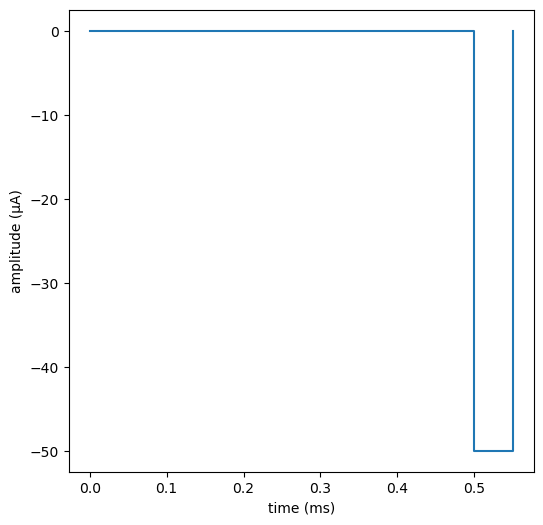

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
stim1.plot(ax)
ax.set_xlabel("time (ms)")
ax.set_ylabel("amplitude (µA)")

We will also create a dummy stimulus, that we will apply to the electrode we don't want to use

In [12]:
I_pulse_dum = 0.1           #pulse amplitude, in µA
T_pulse_dum = 1
dummy_stim = nrv.stimulus()
dummy_stim.pulse(start,-I_pulse_dum,T_pulse_dum)

Electrodes can be simply linked the FEM model by using the ```add_electrode```-method of the ```FEM_stimulation```-object, which combine an ```electrode```-object to a ```stimulus```-object and attach it to the FEM model:

In [13]:
extra_stim.add_electrode(LIFE, stim1)           #ID = 0
extra_stim.add_electrode(cuff, dummy_stim)      #not stim on the cuff - ID = 1

ID of electrode is incremented as we add them to the ``extra_stim``: here the ID for the LIFE is 0 and 1 for the cuff electrode. Let's write it to variable, so we don't mix them later!

In [14]:
ID_LIFE = 0
ID_cuff = 1 

## Connecting the FEM model to the axon and simulating it:
Now it is time to attach the extracellular context to our axon. It can be simply be done with the ``attach_extracellular_stimulation``:

In [15]:
axon_m.attach_extracellular_stimulation(extra_stim)

And simulate it and save the results:

In [16]:
res_LIFE = axon_m(t_sim=3) #3ms simulation

NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 135
NRV INFO: Number of nodes : 7543
NRV INFO: Number of elements : 53039
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 2.0223629474639893 s
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 3.3859097957611084 s


We can plot the axon's membrane voltage across time and space with a colormap:

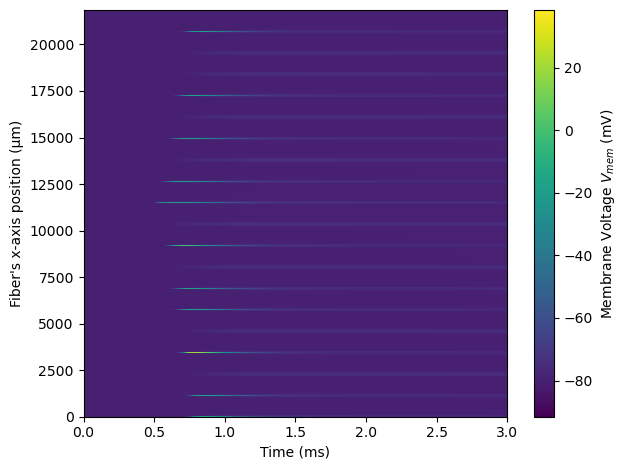

In [17]:
fig, ax = plt.subplots(1)
cbar = res_LIFE.colormap_plot(ax, "V_mem")
ax.set_xlabel('Time (ms)')
ax.set_ylabel("Fiber's x-axis position (µm)")
cbar.set_label(r'Membrane Voltage $V_{mem}$ (mV)')
fig.tight_layout()

We clearly see that the stimulation generated an action potential in the axon! We can automatically detect it with the ``is_recruited`` method of the ``axon_result`` class, which returns true if an AP is detected in the axon:

In [18]:
res_LIFE.is_recruited()

True

Now let's put the ``dummy_stim`` to the LIFE electrode, and re-run the simulation:

In [19]:
axon_m.change_stimulus_from_electrode(ID_LIFE,dummy_stim)
axon_m.change_stimulus_from_electrode(1,dummy_stim)
res_LIFE = axon_m(t_sim=3) 
res_LIFE.is_recruited()

False

As expected, no axon is detected as the axon is not being stimulated! We also observe that the simulation was much faster. Indeed, as long as we do not change the geometrical properties of the model, we do not need to re-run the FEM solver again. 
Let's plot the axon's voltage membrane to verify the statement of the ``is_recruited`` method:

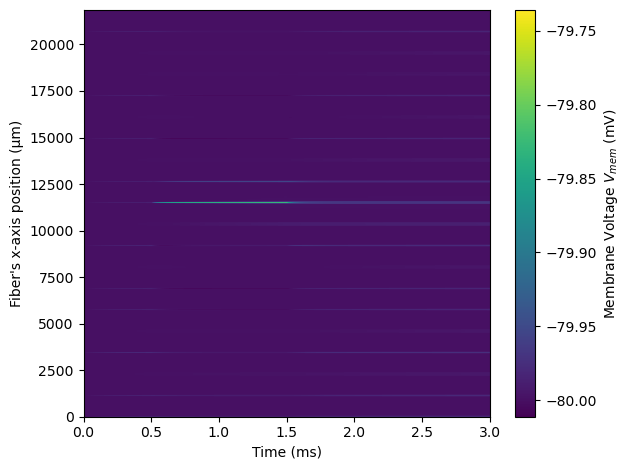

In [20]:
fig, ax = plt.subplots(1)
cbar = res_LIFE.colormap_plot(ax, "V_mem")
ax.set_xlabel('Time (ms)')
ax.set_ylabel("Fiber's x-axis position (µm)")
cbar.set_label(r'Membrane Voltage $V_{mem}$ (mV)')
fig.tight_layout()

And indeed we only see the artifact from the dummy stimulus on the membrane's voltage. Now let's stimulate with the cuff electrode:

In [21]:
axon_m.change_stimulus_from_electrode(ID_cuff,stim1)
res_cuff = axon_m(t_sim=3) 
res_cuff.is_recruited()

False

The axon is not recruited with a 50µs/50µA delivered through the cuff. Let's multiply the stimulation current by four:

In [22]:
axon_m.change_stimulus_from_electrode(ID_cuff,stim1*4)
res_cuff = axon_m(t_sim=3) 
res_cuff.is_recruited()

True

## Stimulation threshold curves

The minimum current required to recruit a fiber is called the activation threshold. This threshold depends upon the type of electrode, the nerve geometry, the axon-to-electrode distance, the shape of the stimulation, the type and diameter of axon, etc. This section describes how to easily find the stimulation threshold of an axon, with a defined extracellular context. For that, we can use the ``axon_AP_threshold`` function from NRV.
First, let's put back the ``dummy_sim`` on both electrodes:

In [23]:
axon_m.change_stimulus_from_electrode(ID_cuff,dummy_stim)
axon_m.change_stimulus_from_electrode(ID_LIFE,dummy_stim)

The ``axon_AP_threshold``function uses an iterative approach based on a binary search method to approximate the activation threshold of an AP. To be as generic as possible, the function is implemented in a way that the user must provide a ``update_func`` that is called between each iteration. The ``update_func`` function updates the stimulation parameters of the axon with the new tested stimulation amplitude. This approach gives enough flexibility to the user to decide of the stimulus shape, number etc. The provided ``update_func`` function must at least have two parameters in this order: ``axon`` which is the nrv's ``axon``-object to update, and ``amp`` which is the new stimulation amplitude. Any other arguments to ``update_func`` can be specified in a dict and pass to ``axon_AP_threshold`` through the ``args_update`` parameters.


In this tutorial, we use an update function to estimate threshold from stimulating with a simple cathodic pulse:

In [24]:
def cathodic_pulse_update(axon,amp, pw, elec_id, start_p = 1):
    stim_1 = nrv.stimulus()
    stim_1.pulse(start_p,-amp,pw)
    axon.change_stimulus_from_electrode(elec_id, stim_1)


#parameters for the waveforms
arg_stim = {'pw':50e-3, 'elec_id':ID_LIFE, 'start_p':start}

max_amp = 300 #maximum search boundary

thr_LIFE = nrv.axon_AP_threshold(axon = axon_m,amp_max = max_amp,
                                        update_func = cathodic_pulse_update, args_update=arg_stim)

print(f'LIFE threshold: {np.round(thr_LIFE,1)}µA')

NRV INFO: Iteration 1, Amp is 300µA ...
NRV INFO: Iteration 1, Amp is 300µA (100.0%)... AP Detected! (in 0.417s)
NRV INFO: Iteration 2, Amp is 0µA (100.0%)... AP Not Detected! (in 0.414s)
NRV INFO: Iteration 3, Amp is 150.0µA (100.0%)... AP Detected! (in 0.413s)
NRV INFO: Iteration 4, Amp is 75.0µA (50.0%)... AP Detected! (in 0.412s)
NRV INFO: Iteration 5, Amp is 37.5µA (50.0%)... AP Detected! (in 0.412s)
NRV INFO: Iteration 6, Amp is 18.75µA (50.0%)... AP Detected! (in 0.413s)
NRV INFO: Iteration 7, Amp is 9.38µA (50.0%)... AP Not Detected! (in 0.41s)
NRV INFO: Iteration 8, Amp is 14.06µA (33.33%)... AP Not Detected! (in 0.414s)
NRV INFO: Iteration 9, Amp is 16.41µA (14.29%)... AP Detected! (in 0.413s)
NRV INFO: Iteration 10, Amp is 15.23µA (7.14%)... AP Not Detected! (in 0.411s)
NRV INFO: Iteration 11, Amp is 15.82µA (3.7%)... AP Not Detected! (in 0.414s)
NRV INFO: Iteration 12, Amp is 16.11µA (1.82%)... AP Detected! (in 0.427s)
NRV INFO: Iteration 13, Amp is 15.97µA (0.91%)... AP No

Let's do the same thing but with the cuff electrode:

In [25]:
axon_m.change_stimulus_from_electrode(ID_LIFE,dummy_stim)   #so LIFE is not stimulating

arg_stim = {'pw':50e-3, 'elec_id':ID_cuff, 'start_p':start}
thr_cuff = nrv.axon_AP_threshold(axon = axon_m,amp_max = max_amp,
                                        update_func = cathodic_pulse_update, args_update=arg_stim)

print(f'cuff threshold: {np.round(thr_cuff,1)}µA')

NRV INFO: Iteration 1, Amp is 300µA ...
NRV INFO: Iteration 1, Amp is 300µA (100.0%)... AP Detected! (in 0.416s)
NRV INFO: Iteration 2, Amp is 0µA (100.0%)... AP Not Detected! (in 0.416s)
NRV INFO: Iteration 3, Amp is 150.0µA (100.0%)... AP Not Detected! (in 0.41s)
NRV INFO: Iteration 4, Amp is 225.0µA (33.33%)... AP Detected! (in 0.412s)
NRV INFO: Iteration 5, Amp is 187.5µA (16.67%)... AP Detected! (in 0.415s)
NRV INFO: Iteration 6, Amp is 168.75µA (10.0%)... AP Detected! (in 0.414s)
NRV INFO: Iteration 7, Amp is 159.38µA (5.56%)... AP Detected! (in 0.412s)
NRV INFO: Iteration 8, Amp is 154.69µA (2.94%)... AP Not Detected! (in 0.412s)
NRV INFO: Iteration 9, Amp is 157.03µA (1.49%)... AP Detected! (in 0.416s)
NRV INFO: Iteration 10, Amp is 155.86µA (0.75%)... AP Detected! (in 0.412s)
NRV INFO: Activation threshold is 155.27µA (0.75%), found in 10 iterations (4.31s).
cuff threshold: 155.3µA


The threshold of LIFE and cuff matches what we observed previously: cuff electrode requires a much higher current than a LIFE to activate a fiber. This result makes sens as extrafascicular electrodes have generally a greater electrode-to-axon distance than intrasfascicular one. 

Let's use the ``axon_AP_threshold`` function to plot threshold vs axon diameter curve, for both when the axon is stimulated with a LIFE and a cuff. Let's start with the LIFE (takes several minutes to run):

In [26]:
if 'extra_stim' in locals():        #Delete extra_stim and axon_m if variable exist (known bug)
    del extra_stim, axon_m   

axon_d_l = [2,4,6,8,10,12,14,16,18,20]        #axon diameter list, in µm
LIFE_thr_l = []                               #list of results
n_NoR = 31                                     #increase NoR so small axons are not too short
nrv.parameters.set_nrv_verbosity(i=2)

for axon_d in axon_d_l:

    #we create a new axon
    L_a = nrv.get_length_from_nodes(axon_d, n_NoR)                              
    new_axon = nrv.myelinated(y=y_a, z=z_a, d=axon_d, L=L_a, model='MRG', rec='nodes')

    #we create a corresponding extracellular context
    extra_stim_f = nrv.FEM_stimulation(endo_mat='endoneurium_ranck')
    extra_stim_f.reshape_nerve(d_n,L_a)
    extra_stim_f.reshape_outerBox(d_outbox)
    extra_stim_f.reshape_fascicle(geometry=geom_f)

    #same for the LIFE
    x_LIFE = new_axon.x_nodes[n_NoR//2]	# LIFE x position, in [um]
    x_LIFE_offset = x_LIFE - (LIFE_l/2)
    new_LIFE = nrv.LIFE_electrode('LIFE_1', LIFE_d, LIFE_l, x_LIFE_offset, y_LIFE, z_LIFE)
    extra_stim_f.add_electrode(new_LIFE, dummy_stim)  #ID = 0

    #link the extrastim with the axon: 
    new_axon.attach_extracellular_stimulation(extra_stim_f)
    new_axon.get_electrodes_footprints_on_axon()

    #parameters for the waveforms
    max_amp = 150 #maximum search boundary
    arg_stim = {'pw':50e-3, 'elec_id':0, 'start_p':start}
    thr_LIFE = nrv.axon_AP_threshold(axon = new_axon,amp_max = max_amp,
                                            update_func = cathodic_pulse_update, args_update=arg_stim)
    del extra_stim_f, new_axon                       #to prevent meshing error (known bug)

    print(f'LIFE threshold: {np.round(thr_LIFE,1)}µA (axon_d = {axon_d}µm)')                        
    LIFE_thr_l.append(thr_LIFE)


NRV WARNING: [6000.00537109    0.            0.        ] not found in mesh, value of [6000.    0.    0.] reused
LIFE threshold: 69.4µA (axon_d = 2µm)
LIFE threshold: 35.3µA (axon_d = 4µm)
LIFE threshold: 23.8µA (axon_d = 6µm)
LIFE threshold: 18.7µA (axon_d = 8µm)
LIFE threshold: 16.5µA (axon_d = 10µm)
LIFE threshold: 15.5µA (axon_d = 12µm)
LIFE threshold: 14.9µA (axon_d = 14µm)
LIFE threshold: 14.4µA (axon_d = 16µm)
LIFE threshold: 14.0µA (axon_d = 18µm)
LIFE threshold: 13.7µA (axon_d = 20µm)


Lets to the same curve but with a cuff electrode this time. To speed up the computation, we will use parallel computation to speed up the process. For this specific case of threshold's search, we can use the NRV's built-in function ``search_threshold_dispatcher``. This function needs as parameters a function ``process_threshold`` to call, and a list of parameters for which the ``process_threshold`` function will be called in parallel. Let's write the ``process_threshold`` function for our example:

.. Warning::

    The funtion ``search_threshold_dispatcher`` does not work correctly in Jupyter Notebooks. 

.. tip::

    To speed up the process, in a `.py` file:
    .. code-block:: python

        cuff_thr_l = []
        for _i, _d in enumerate(axon_d_l):
            print(f"{_i}/{len(axon_d_l)}")
            cuff_thr_l += process_threshold(_d)

    Could be replaced by:

    .. code-block:: python

        ncore = 4
        cuff_thr_l = nrv.search_threshold_dispatcher(process_threshold,axon_d_l, ncore=ncore)



In [ ]:
def process_threshold(axon_d):
    #we create a new axon
    L_a = nrv.get_length_from_nodes(axon_d, n_NoR)                              
    new_axon = nrv.myelinated(y=y_a, z=z_a, d=axon_d, L=L_a, model='MRG', rec='nodes')

    #we create a corresponding extracellular context
    extra_stim_f = nrv.FEM_stimulation(endo_mat='endoneurium_ranck')
    extra_stim_f.reshape_nerve(d_n,L_a)
    extra_stim_f.reshape_outerBox(d_outbox)
    extra_stim_f.reshape_fascicle(geometry=geom_f)

    #same for the LIFE
    x_cuff = new_axon.x_nodes[n_NoR//2] # cuff z position, in [um]
    new_cuff = nrv.CUFF_electrode('CUFF_1', contact_length=contact_width,
            contact_thickness=contact_thickness, insulator_length=insulator_width,
            insulator_thickness=insulator_thickness, x_center=x_cuff)
    extra_stim_f.add_electrode(new_cuff, dummy_stim)  #ID = 0

    #link the extrastim with the axon: 
    new_axon.attach_extracellular_stimulation(extra_stim_f)
    new_axon.get_electrodes_footprints_on_axon()

    #parameters for the waveforms
    max_amp = 1500 #maximum search boundary
    arg_stim = {'pw':50e-3, 'elec_id':0, 'start_p':start}
    threshold = nrv.axon_AP_threshold(axon = new_axon,amp_max = max_amp,
                                            update_func = cathodic_pulse_update, args_update=arg_stim)
    
    del extra_stim_f,new_axon #to prevent meshing error (known bug)
    return(threshold)


# In a Notebook:
cuff_thr_l = []
for _i, _d in enumerate(axon_d_l):
    print(f"{_i}/{len(axon_d_l)}")
    cuff_thr_l += process_threshold(_d)

# In a .py file could be parallelised with
# ncore = 4
# cuff_thr_l = nrv.search_threshold_dispatcher(process_threshold,axon_d_l, ncore=ncore)


0/10
NRV WARNING: [6000.00537109    0.            0.        ] not found in mesh, value of [6000.    0.    0.] reused
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10


Now we can plot the results to compare the recruitment properties of the two tested electrodes:

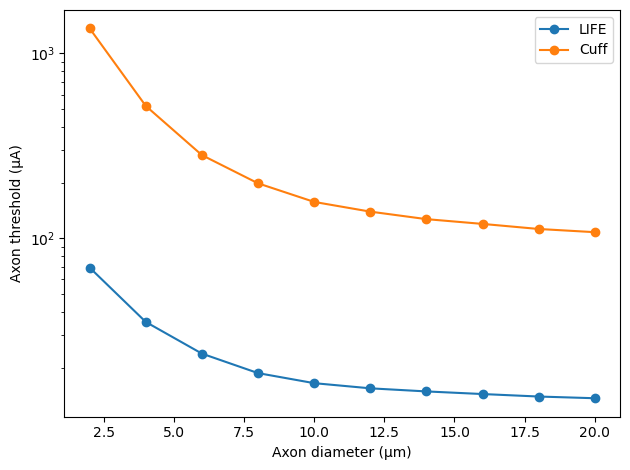

In [28]:
fig, ax = plt.subplots()
ax.semilogy(axon_d_l,LIFE_thr_l,'o-',label = 'LIFE')
ax.semilogy(axon_d_l,cuff_thr_l,'o-',label = 'Cuff')
ax.legend()
ax.set_xlabel("Axon diameter (µm)")
ax.set_ylabel("Axon threshold (µA)")
fig.tight_layout()